In [16]:

import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

import torch
from torch import nn, einsum
import torch.nn.functional as F

import torchvision
from torch.optim import Adam
from torchvision import transforms as T, utils
from torch.utils.data import DataLoader

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange

from tqdm.auto import tqdm
from ema_pytorch import EMA

from accelerate import Accelerator

import os

from denoising_diffusion_pytorch.fid_evaluation import FIDEvaluation

from classifier_free_guidance import Unet, GaussianDiffusion
import time
from glob import glob
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
def get_data(image_size, folder, batch_size):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_size),  # args.image_size + 1/4 *args.image_size
        torchvision.transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        torchvision.transforms.ToTensor()
    ])
    dataset = torchvision.datasets.ImageFolder(folder, transform=transforms)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    return dataloader

In [3]:
def cycle(dl):
    while True:
        for data in dl:
            yield data

In [4]:
accelerator = Accelerator(
    split_batches = True,
    mixed_precision = 'fp16'
)

In [5]:
dl = get_data(256, '/home/yoos-bii/Desktop/data_tct/val', 1)
dl

In [6]:
dl = accelerator.prepare(dl)
dl = cycle(dl)

In [7]:
model = Unet(
        dim = 64,
        dim_mults = (1, 2, 4, 8),
        num_classes = 15,
        cond_drop_prob = 0.5
    ).cuda()

diffusion = GaussianDiffusion(
    model,
    image_size = 256,
    timesteps = 1000,
    sampling_timesteps=250,
    loss_type='l2'
).cuda()

In [8]:
opt = Adam(diffusion.parameters(), lr = 1e-4, betas = (0.9, 0.99))

In [9]:
data = torch.load(os.path.join('/home/yoos-bii/Desktop/workspace/diffusion_digital_pathology/Checkpoint-diffusion/results_cond_512TO256_GTEX', f'model-{30}.pt'), map_location=accelerator.device)

# print(data['opt'])

model = accelerator.unwrap_model(diffusion)
model.load_state_dict(data['model'])

# opt = opt.load_state_dict(data['opt'])

<All keys matched successfully>

In [10]:
ema = EMA(model, beta = (0.9, 0.99), update_every = 0.995)
ema = ema.to(accelerator.device)

ema.load_state_dict(data['ema'])

<All keys matched successfully>

In [11]:
for ii in range(15):
    val_imgs = glob(f'/home/yoos-bii/Desktop/data_tct/val/{str(ii)}/*.png')
    print(ii, '----------->', len(val_imgs))
    

0 -----------> 1046
1 -----------> 1200
2 -----------> 1200
3 -----------> 1200
4 -----------> 1200
5 -----------> 1200
6 -----------> 1200
7 -----------> 1200
8 -----------> 1200
9 -----------> 1200
10 -----------> 1200
11 -----------> 1200
12 -----------> 1200
13 -----------> 1200
14 -----------> 1200


In [12]:
# [0 for _ in range(1046)]

In [ ]:
# start_time = time.time()
for kk in range(15):
    gen_list = [] 
    for ii in tqdm(range(100)):
        one_image_per_class = torch.tensor([kk]).to(accelerator.device) # suche that we sample one image per calss
        all_images_list = list(ema.ema_model.sample(classes=one_image_per_class, cond_scale=3.))
        gen_list.append(all_images_list[0].cpu().numpy().transpose(1, 2, 0))
        
    gen_list_arr = np.reshape(gen_list, [-1, 256, 256, 3]) 
    np.save(f'/home/yoos-bii/Desktop/workspace/diffusion_digital_pathology/Checkpoint-diffusion/results_cond_512TO256_GTEX/class_{str(kk)}.npy', gen_list_arr)
    
    # break
# end_time = time.time()

# print('Time taken to sample one image per class:', end_time - start_time)


In [12]:
gen_list_test = gen_list.copy()

In [15]:
# len(gen_list_test)
gen_list_test_arr = np.reshape(gen_list_test, [-1, 256, 256, 3])
gen_list_test_arr.shape

(2, 256, 256, 3)

In [35]:
type(all_images_list[0].cpu().numpy())

numpy.ndarray

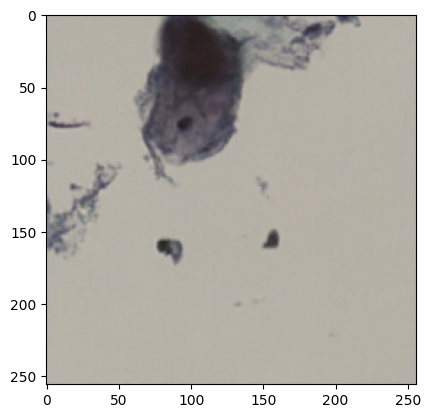

In [37]:
import matplotlib.pyplot as plt 

plt.imshow(all_images_list[0].cpu().numpy().transpose(1, 2, 0))

In [ ]:
with torch.inference_mode():
    all_images_list = list(ema.ema_model.sample(classes=one_image_per_class, cond_scale=3.))
    # ema.ema_model.p_sample_loop()

In [18]:
path = '/home/yoos-bii/Desktop/workspace/diffusion_digital_pathology/Checkpoint-diffusion/results_cond_512TO256_GTEX'


for ii in range(15):
    npy_path = os.path.join(path, f'class_{str(ii)}.npy')
    npy_load = np.load(npy_path)
    
    # print(npy_load.shape)
    # break
    for kk, npy in enumerate(npy_load):
        # print(npy.shape)
        plt.imshow(npy)
        plt.axis('off')  # Turn off axis
        plt.savefig(os.path.join(path, 'output_images', f'output_image_class{str(ii)}_{str(kk)}.png'))  # Save the image without displaying
        plt.close()  # Close the plot to avoid displaying it


In [36]:
import random 
from PIL import Image
from pathlib import Path

for iii in range(15):

    # folder_path = Path(f'/)
    image_files = glob(os.path.join(f'/home/yoos-bii/Desktop/data_tct/train/{str(iii)}','*.png'))
    selected_images = random.sample(image_files, 100)
    
    output_directory = Path(f'/home/yoos-bii/Desktop/workspace/diffusion_digital_pathology/Checkpoint-diffusion/original_images/{str(iii)}')
    output_directory.mkdir(exist_ok=True)
    
    # selected_images

    for selected_img in selected_images:
        selected_name = selected_img.split('/')[-1]
        # print(selected_name)
        # break 
    
    # break 
        with Image.open(selected_img) as img:
            # Resize the image
            img_resized = img.resize((256, 256))
            
            # Save the resized image
            output_path = os.path.join(output_directory, selected_name)
            img_resized.save(output_path)

In [8]:
from torchvision.transforms import functional as F
from glob import glob
import numpy as np
from PIL import Image


def preprocess_image(image):
    image = torch.tensor(image).unsqueeze(0)
    image = image.permute(0, 3, 1, 2) / 255.0
    return F.center_crop(image, (256, 256))

real_images_path = glob('/home/yoos-bii/Desktop/workspace/diffusion_digital_pathology/Checkpoint-diffusion/original_images/0/*.png')
real_images = [np.array(Image.open(path).convert("RGB")) for path in real_images_path]
real_images = torch.cat([preprocess_image(image) for image in real_images])

fake_images_path = glob('/home/yoos-bii/Desktop/workspace/diffusion_digital_pathology/Checkpoint-diffusion/results_cond_512TO256_GTEX/output_images/0/*.png')
fake_images = [np.array(Image.open(path).convert("RGB")) for path in fake_images_path]
fake_images = torch.cat([preprocess_image(image) for image in fake_images])


print(real_images.shape)

torch.Size([100, 3, 256, 256])


In [26]:
print(real_images.shape)
print(fake_images.shape)

torch.Size([100, 3, 256, 256])
torch.Size([101, 3, 256, 256])


In [35]:
from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(normalize=True)
fid.update(real_images, real=True)
fid.update(fake_images, real=False)

print(f"FID: {float(fid.compute())}")

ModuleNotFoundError: FrechetInceptionDistance metric requires that `Torch-fidelity` is installed. Either install as `pip install torchmetrics[image]` or `pip install torch-fidelity`.

In [29]:
# !pip install torch-fidelity
# !pip3 install torch-fidelity
# !pip3 install torchmetrics
# !pip3 install torchmetrics
# !pip3 install torchmetrics[image]
!pip install torchmetrics[image] torch-fidelity

Defaulting to user installation because normal site-packages is not writeable


In [11]:
# model, opt = accelerator.prepare(model, opt)

In [12]:
# model, opt 
# print(opt)

In [13]:
fid_score = FIDEvaluation(
    batch_size = 1, 
    dl=dl, 
    sampler=ema.ema_model, 
    # sampler=load_model,
    channels=3,
    accelerator=accelerator,
    stats_dir='/home/yoos-bii/Desktop/workspace/diffusion_digital_pathology/Checkpoint-diffusion/output_fid',
    device=accelerator.device, 
    num_fid_samples=50000,
    inception_block_idx=2048
)

In [14]:
get_fid_score = fid_score.fid_score()


Stacking Inception features for 50000 samples from the real dataset.


  0%|          | 0/50000 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'to'